#### THINGS TO ADD
- PLL full module diagram
- PED diagram
- Loop Filter diagram
- DDS diagram
- clean imports and disc
- talk to luke about pll plots conveging to zero

### PLL Implementation

The following phase locked loop (PLL) system illustrates the core elements used to construct a PLL as well as later its use in a QPSK system. Phase locked loops are used in communications systems to synchronize a output signal with a input reference signal which is useful for correcting small unkown phase and frequency offsets in the received signal. The first submodule is a phase detector which calculates the phase difference between in the input reference signal and the PLL output, this term represents the instantaneous phase error. The phase error is then fed into a loop filter then into a digital direct synthesizer (DDS) which generates the output signal. This process is represented below in Figure 1.

FIGURE 1 HERE
<!-- <div style="text-align: center;">
    <img src="./images/QPSK/transmitter_receiver_diagram.png" alt="" width="750" />
    <p>QPSK System Transmitter and Receiver Architecture</p>
</div> -->

#### Imports and Library Functions
talk about library and imports here

In [1]:
from helper_functions import sp_library as sp
import numpy as np
import matplotlib.pyplot as plt

#### Phase Error Detector
The phase error detector module takes two reference signals as input, computes the phase of both, and outputs the difference between the two. The phases of the signals are obtained by effectivly taking the inverse tangents of a complex signal point for each signal and then adjusting the resulting phase based on the assumed quadrant of each point. This process is derived below

$$
\theta _o\left(nT\right)\:=\:\tan ^{-1}\left(\frac{x_{imag}\left(nT\right)}{x_{real}\left(nT\right)}\right) \quad \quad \quad \theta _i\left(nT\right)\:=\:\tan ^{-1}\left(\frac{x_{imag}\left(nT\right)}{x_{real}\left(nT\right)}\right)
$$

$$
e\left(nT\right)=\Delta \:\theta \:\left(nT\right)=\theta \:_o\left(nT\right)-\theta \:_i\left(nT\right)
$$

where:
- $i$ represents the input reference signal,
- $o$ represents the output signal,
- $nT$ is the instantaneous sample,
- $e(nT)$ is the detected phase error.

The following excerpt shoes the phase detector implementation that is later used in the 

In [2]:
def phase_error_detector(sample1, sample2):
    angle = np.angle(sample2) - np.angle(sample1)
    if angle > np.pi:
        angle -= 2 * np.pi
    elif angle < -np.pi:
        angle += 2 * np.pi
    return angle

# test case 1
sample1 = 0
sample2 = 1 + 1j
ped_output = phase_error_detector(sample1, sample2)
print(f"\nTest case 1 output: {np.degrees(ped_output)} deg")

# test case 2
sample1 = 1 - 1j
sample2 = 1 + 1j
ped_output = phase_error_detector(sample1, sample2)
print(f"Test case 2 output: {np.degrees(ped_output)} deg\n")


Test case 1 output: 45.0 deg
Test case 2 output: 90.0 deg



#### Loop Filter

The loop filter module procides stability for the overall PLL system by shaping the closed-loop frequency, or transient response. During instantiation of a PLL system, for this example a PLL object, a loop bandwidth and damping factor are defined as parameters shaping this transient response. The loop bandwidth specifies the speed at which the PLL will converge towards matching the input reference signal, setting a wider loop bandwidth allows the PLL to respond more rapidly respond to input frequency changes but introduces more internal noise. The damping factor, often represented as $\zeta$ specifies how the oscillations decay in the transient response when a input frequency change is introduced. Together these parameters categorize the loop filter coefficients $K_1$ and $K_2$ which are derived below.

LOOP FILTER DIAGRAM HERE

$$
K_1 = \frac{4 \xi \left( \frac{B_n T_s}{\zeta + \frac{1}{4 \zeta}} \right)}{1 + 2 \zeta \left( \frac{B_{nT} T_s}{\zeta + \frac{1}{4 \zeta}} \right) + \left( \frac{B_{nT} T_s}{\zeta + \frac{1}{4 \zeta}} \right)^2} \quad \quad \quad K_2 = \frac{4 \left( \frac{B_n T_s}{\zeta + \frac{1}{4 \zeta}} \right)^2}{1 + 2 \zeta \left( \frac{B_{nT} T_s}{\zeta + \frac{1}{4 \zeta}} \right) + \left( \frac{B_{nT} T_s}{\zeta + \frac{1}{4 \zeta}} \right)^2}
$$

where:
- $B_n$ represents the loop bandwidth (usually normalized for the sample rate $f_s$),
- $\zeta$ represents the damping factor,
- $T_s$ is the sampling period of the system.

In [12]:
def compute_loop_constants(fs, lb, df):
    denominator = 1 + ((2 * df) * ((lb * (1 / fs)) / (df + (1 / (4 * df))))) + ((lb * (1 / fs)) / (df + (1 / (4 * df)))) ** 2
    K1 = ((4 * df) * ((lb * (1 / fs)) / (df + (1 / (4 * df))))) / denominator
    K2 = (((lb * (1 / fs)) / (df + (1 / (4 * df)))) ** 2) / denominator
    return K1, K2

sample_rate = 8
loop_bandwidth = 0.02 * sample_rate
damping_factor = 1 / np.sqrt(2)
k1, k2 = compute_loop_constants(sample_rate, loop_bandwidth, damping_factor)

print("\n Loop Filter Configuration Parameters")
print(f"Sample Rate: {sample_rate}")
print(f"Loop Bandwidth: {loop_bandwidth}")
print(f"Damping Factor: {np.round(damping_factor, 5)}")
print(f"Loop Filter Coefficient K1: {np.round(k1, 5)}")
print(f"Loop Filter Coefficient K2: {np.round(k2, 5)}\n")


Sample Rate: 8
Loop Bandwidth: 0.16
Damping Factor: 0.70711
Loop Filter Coefficient K1: 0.05193
Loop Filter Coefficient K2: 0.00035



### DDS
The direct digital synthesizer module takes the output of the loop filter (the filtered phase error) and uses this value to produce a complex sinusoid output signal. This process is shown below in #Figure X# which uses a feedback architecture to sum the previous output, the current output, and a reference frequency (assuming you have an idea of where your center frequency is located) which is then fed into a complex multiplier. The complex multiplier module represents two seperate channels in which the first a cosine is applied to the input and the second a sine, these calculations are applied via the CORDiC algorithm which will be discussed in a later example.

DDS DIAGRAM HERE

$$
e^{j\left(\cdot \right)}=cos\left(\cdot \right)\:+\:jsin\left(\cdot \right)
$$

The diagram above shows a gain, $K_0$, being applied to the DDS input, this is value can be used as a normalization coeffienct or a way of inverting the output signal.

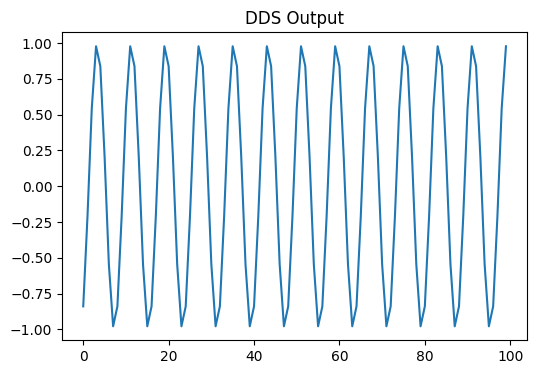

In [14]:
def DDS(fs, n, v, f0, k0):
    phase = v * k0
    output = np.exp(1j * (2 * np.pi * (f0 / fs) * n + phase))
    return output

fs = 8 # sample rate
n = np.arange(0, 100) # sample indicies
v = 1.0 # defined loop filter output
k0 = 1.0 # normalization coefficient
f0 = 10 # assumed frequency of input

output = DDS(sample_rate, n, v, k0, f0)

plt.figure(figsize=(6, 4))
plt.plot(np.real(output))
plt.title("DDS Output")
plt.show()

### Full System Test

Now that each of the submodules have been defined the full PLL system can be tested. This module is defined as a class within the helper functions code as is run in stream mode where a single sample of the complex reference input signal goes in, and a single sample of the output signal comes out. A reference signal is generated for testing purposes as well as a set of arrays declared for tracking of the PLL's internal variables including the detected phase error, loop filter output, and input and output reference signal samples.

In [15]:
fs = 500 

sig_freq = 10
sig_phase = np.pi / 4
n = np.arange(0,1000)
input_signal = np.exp(1j * ((2 * np.pi * (sig_freq) / fs) * n + (sig_phase)))

# simulation results record
pll_input = []
pll_output = []
pll_detected_phase_record = []
pll_error_record = []

Next the PLL module can be instantiated using the system sample rate as well as a specified loop bandwidth and damping factor.

In [18]:
loop_bandwidth = 0.02 * fs
damping_factor = 1 / np.sqrt(2)
pll = sp.PLL(fs, loop_bandwidth=loop_bandwidth, damping_factor=damping_factor)

# Print loop filter gains for reference
print("\nPLL Configuration Parameters")
print(f"K0: {pll.K0}")
print(f"K1: {np.round(pll.K1, 5)}")
print(f"K2: {np.round(pll.K2, 5)}\n")


PLL Configuration Parameters
K0: 1
K1: 0.05193
K2: 0.00035



Finally the simulation can be run in a sequential fashion mirroring that of what a real-time streaming system would look like.

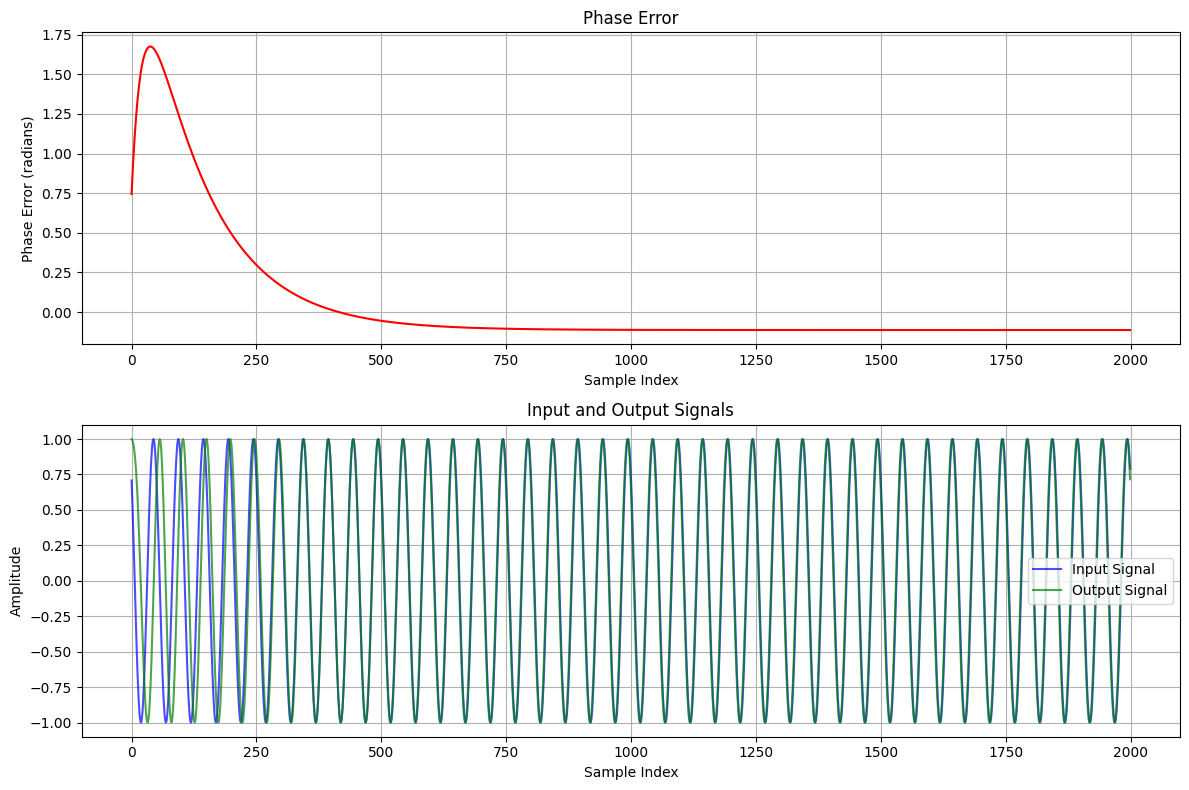

In [20]:
for i in range(len(n)):
    # insert the new sample into the PLL
    output_signal = pll.insert_new_sample(input_signal[i], i)
    
    # record detected phase and error
    detected_phase = pll.get_current_phase()
    error = pll.phase_detector(output_signal, input_signal[i])

    # update records
    pll_input.append(input_signal[i])
    pll_output.append(output_signal)
    pll_detected_phase_record.append(detected_phase)
    pll_error_record.append(error)

# plotting the phase error and input/output signal results
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(pll_error_record, label='Phase Error', color='r')
plt.title('Phase Error')
plt.xlabel('Sample Index')
plt.ylabel('Phase Error (radians)')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(np.real(pll_input), label='Input Signal', color='b', alpha=0.7)
plt.plot(np.real(pll_output), label='Output Signal', color='g', alpha=0.7)
plt.title('Input and Output Signals')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()